True

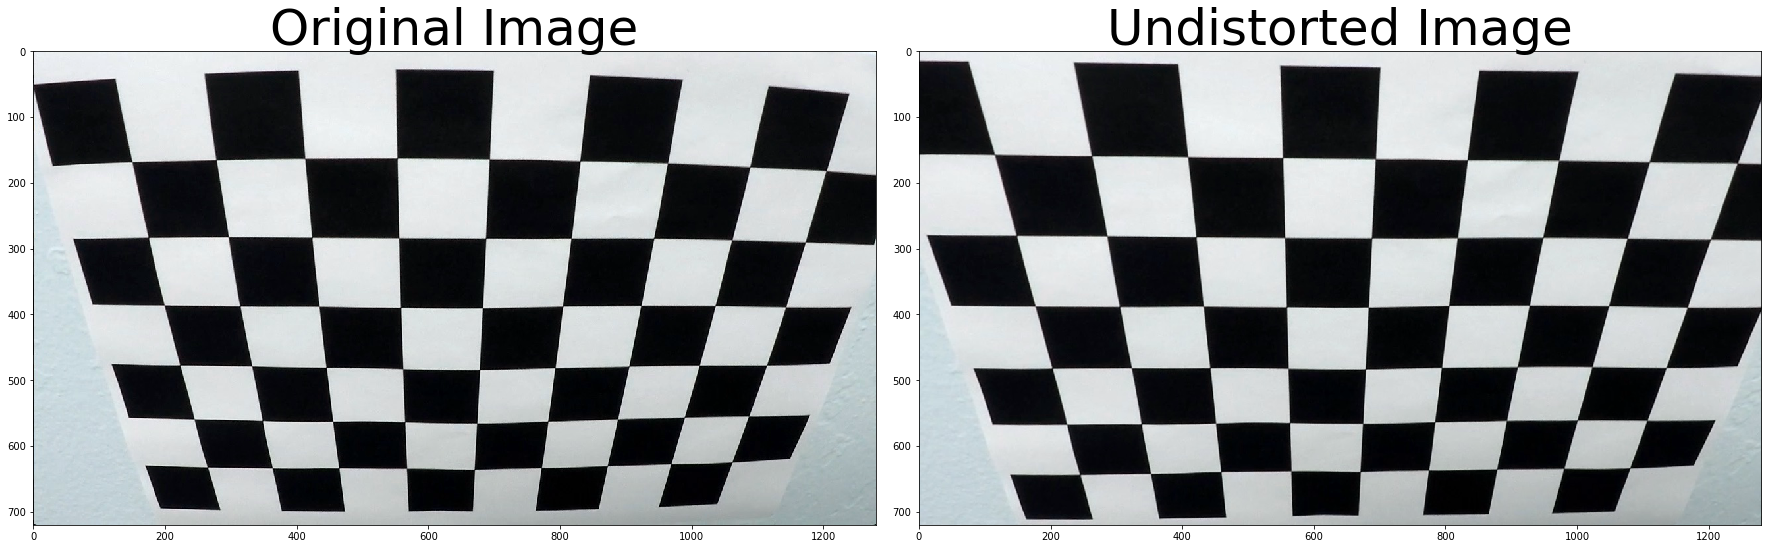

In [108]:
#import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

#Camera calibration afunction

# Read in an image
img = cv2.imread('camera_cal/calibration2.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_warped_undistort(img, nx=9, ny=6):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    # Prepare object points 
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Finding chessboard corners (for an 9x6 board):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Drawing detected corners on an image:
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # Add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
    # Camera calibration, given object points, image points, and the shape of the grayscale image:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist
mtx, dist = cal_warped_undistort(img)
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Display for debug purpose
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('output_images/Undistorted chessboard.jpg',undistort)

True

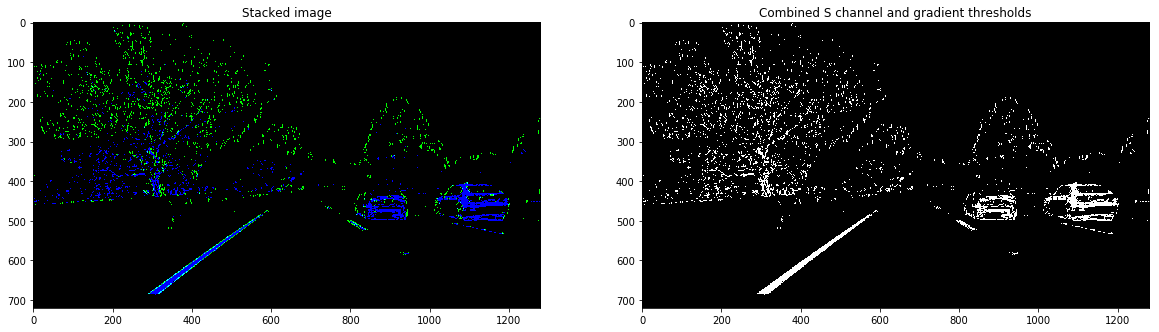

In [152]:
# Find the best color and gradient combination and thresholds with the test images.Then define the function to create thresholded binary image
# for pipeline use

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
img = cv2.imread('test_images/test6.jpg')
def thresholded_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 60
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, color_binary

combined_binary, color_binary = thresholded_binary(img)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked image')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

cv2.imwrite('output_images/Binary_img.jpg',combined_binary)

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


True

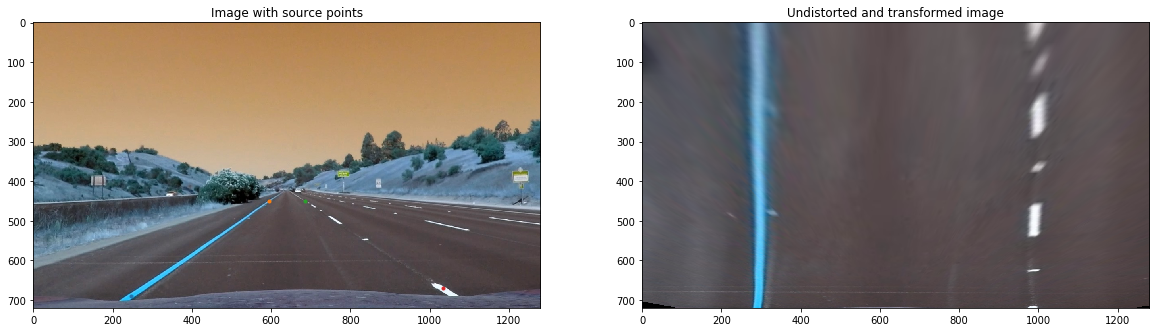

In [126]:
# Find the perspective transform point and test the transform
def undistort_transform(img):
    img_size = (img.shape[1], img.shape[0])
    #undistort first
    mtx, dist = cal_warped_undistort(cv2.imread('camera_cal/calibration2.jpg'))
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    src = np.float32(
    [
        [246,690],
        [594,450],
        [685,450],
        [1035,670]
    ])
    dst = np.float32(
    [
        [(img.shape[1]-700)//2,img.shape[0]],
        [(img.shape[1]-700)//2,0],
        [img.shape[1]-(img.shape[1]-700)//2,0],
        [img.shape[1]-(img.shape[1]-700)//2,img.shape[0]]
    ])
    #print(dst)
    #Transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped =cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, undist, M, Minv


img = cv2.imread('test_images/straight_lines1.jpg')
# mtx, dist = cal_warped_undistort(cv2.imread('camera_cal/calibration2.jpg'))
# print(mtx,dist)
# undist = cv2.undistort(cali_img, mtx, dist, None, mtx)
# Plotting thresholded images
undistort_transform_cali, undistort, M, Minv = undistort_transform(img)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Image with source points')
# For debug only
ax1.imshow(undistort)
ax1.plot(246,690,".")
ax1.plot(594,450,".")
ax1.plot(685,450,".")
ax1.plot(1035,670,".")
ax2.set_title('Undistorted and transformed image')
ax2.imshow(undistort_transform_cali)

cv2.imwrite('Image with source points identified.jpg',undistort)
cv2.imwrite('Undistorted and transformed image.jpg',undistort_transform_cali)
# The outputed second-column images are not actually something I felt as promising as undistorted, though they are different from the original


In [160]:
#Functions for finding lane pixels and fitting polynomial functions
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*1.1//2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # The amount deviate from lane center
    deviate = (leftx_base + rightx_base)/2 - midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, deviate

#base poly fit
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, deviate = find_lane_pixels(binary_warped)

    try:
        global left_line
        global right_line
        #x and y values for detected line pixels
        left_line.allx = leftx 
        left_line.ally = lefty 
        right_line.allx = rightx 
        right_line.ally = righty 
    except:
        print("")
        
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        flag = 1
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        flag = 0

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    

    return out_img, left_fit, right_fit, deviate, flag, left_fitx, right_fitx

#used to iterate to find new poly
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img, left_fit, right_fit, deviate, flag, init_left_fitx, init_right_fitx = fit_polynomial(binary_warped)
    # print(left_fit)
    try:
        global left_line
        global right_line
        #difference in fit coefficients between last and new fits
        if left_line.current_fit is not None:
            left_line.diffs = left_line.current_fit - left_fit
        if right_line.current_fit is not None:
            right_line.diffs = right_line.current_fit - right_fit
        #if right_line.diffs**2 + left_line.diffs**2 > 
        # was the line detected in the last iteration?
        left_line.detected = bool(flag)
        right_line.detected = bool(flag) 
        #polynomial coefficients for the most recent fit
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
    except:
        print("")
        
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials based on the previous fit
    left_fitx, right_fitx, ploty, new_left_fit, new_right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    #determine if bad fit, correct with previous calculations
    if ((left_line.diffs is not np.array([0,0,0], dtype='float'))&(right_line.diffs is not np.array([0,0,0], dtype='float')))&(left_line.bestx is not None)&(right_line.bestx is not None):
        if not ((left_line.detected & left_line.detected == True)&((right_line.diffs < 0.1*right_line.current_fit).all()) \
                &((left_line.diffs > 0.1*left_line.current_fit).all())) \
                &((sum(right_fitx)/len(right_fitx) - sum(left_fitx)/len(right_fitx))<1.1*(sum(right_line.bestx)/len(right_line.bestx) - sum(left_line.bestx)/len(left_line.bestx))) \
                &((sum(right_fitx)/len(right_fitx) - sum(left_fitx)/len(right_fitx))>0.9*(sum(right_line.bestx)/len(right_line.bestx) - sum(left_line.bestx)/len(left_line.bestx))):
            left_fitx = left_line.bestx
            right_fitx = right_line.bestx
            #deviate = left_line.line_base_pos

        
    # Update the creteria
    try:
        #distance in pixels of vehicle center from the line
        left_line.line_base_pos = deviate
        right_line.line_base_pos = deviate
        # Store last 4 fits in the class
        if len(left_line.recent_xfitted)>3:
            left_line.recent_xfitted.pop(0)
            right_line.recent_xfitted.pop(0)
            left_line.recent_xfitted.append(init_left_fitx)
            right_line.recent_xfitted.append(init_right_fitx)   
        else:
            left_line.recent_xfitted.append(init_left_fitx)
            right_line.recent_xfitted.append(init_right_fitx)
        #average x values of the fitted line over the last n iterations   
        left_line.bestx = (sum(left_line.recent_xfitted) /len(left_line.recent_xfitted))
        right_line.bestx = (sum(right_line.recent_xfitted) /len(right_line.recent_xfitted))
    except:
        print("")
    #plt.imshow(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    # print(left_fitx, ploty)
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)
    #plt.imshow(window_img)
    # Plot the polynomial lines onto the image
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return result, ploty, left_fit, right_fit, deviate, window_img

#Calculate Curvature
def measure_curvature_real(ploty, left_fit, right_fit):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    try:
        global left_line
        global right_line
        #radius of curvature of the line in meter
        left_line.radius_of_curvature = left_curverad
        right_line.radius_of_curvature = right_curverad
    except:
        print("")
        
    return left_curverad, right_curverad

#combine images
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


True

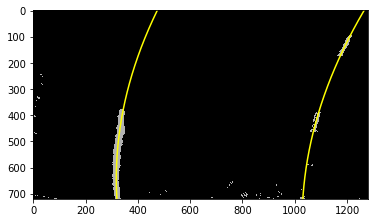

In [159]:
# Pipeline for Images
def pipeline_img(img):
    undist, temp, M, Minv = undistort_transform(img)
    binary_warped, undist = thresholded_binary(undist)
    #x meter per pix to calculate real offset
    xm_per_pix = 3.7/700
#     plt.imshow(img)
#     print(img.shape)
#     print(img[200,0])
    out_img, ploty, left_fit, right_fit, deviate, poly_img = search_around_poly(binary_warped)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    if deviate < 0:
        side = "right"
    else:
        side = "left"
    # get a font
#     fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 40)
#     # make a blank image for the text, initialized to transparent text color
#     txt = Image.new('RGBA', img.shape[:2], (255,255,255,0))
#     # get a drawing context
#     txt_img= ImageDraw.Draw(txt)
#     # draw text, full opacity
#     txt_img.text((10,60), "Left curvature: "+str(left_curverad)+" m; Right curvature: "+str(right_curverad)+" m.", font=fnt, fill=(255,255,255,255))
   
    #add poly image to original image
    transform_poly = cv2.warpPerspective(poly_img, Minv, (poly_img.shape[1], poly_img.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, transform_poly, 0.3, 0)
    poly_img_final = cv2.addWeighted(out_img, 1, poly_img, 0.3, 0)
    curvature_included_img = cv2.putText(result, text="Left curvature: "+str(round(left_curverad,0))+"m; Right curvature: "+str(round(right_curverad,0))+"m.", org=(10,40),fontFace=3, fontScale=1.3, color=(255,255,255), thickness=2)
    txt_img = cv2.putText(curvature_included_img, text="Car is "+str(round(deviate*xm_per_pix ,2))+"m "+side+" of center", org=(10,90),fontFace=3, fontScale=1.3, color=(255,255,255), thickness=2)
    return txt_img, poly_img_final
img = cv2.imread('test_images/test1.jpg')
#correct image color
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
out_img, poly_img_final = pipeline_img(img)
plt.imshow(poly_img_final)
#cv2.imwrite('Poly_fit.jpg',poly_img_final)

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


True

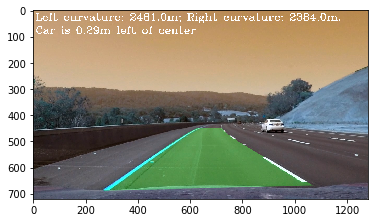

In [147]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
# Pipeline for Videos
def pipeline_vid(img):
    global left_line
    global right_line
    undist, temp, M, Minv = undistort_transform(img)
    binary_warped, undist = thresholded_binary(undist)
    #x meter per pix to calculate real offset
    xm_per_pix = 3.7/700
#     plt.imshow(img)
#     print(img.shape)
#     print(img[200,0])
    out_img, ploty, left_fit, right_fit, deviate, poly_img = search_around_poly(binary_warped)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    if deviate < 0:
        side = "right"
    else:
        side = "left"
    # get a font
#     fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 40)
#     # make a blank image for the text, initialized to transparent text color
#     txt = Image.new('RGBA', img.shape[:2], (255,255,255,0))
#     # get a drawing context
#     txt_img= ImageDraw.Draw(txt)
#     # draw text, full opacity
#     txt_img.text((10,60), "Left curvature: "+str(left_curverad)+" m; Right curvature: "+str(right_curverad)+" m.", font=fnt, fill=(255,255,255,255))
   
    #add poly image to original image
    transform_poly = cv2.warpPerspective(poly_img, Minv, (poly_img.shape[1], poly_img.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, transform_poly, 0.3, 0)
    
    curvature_included_img = cv2.putText(result, text="Left curvature: "+str(round(left_curverad,0))+"m; Right curvature: "+str(round(right_curverad,0))+"m.", org=(10,40),fontFace=3, fontScale=1.3, color=(255,255,255), thickness=2)
    txt_img = cv2.putText(curvature_included_img, text="Car is "+str(abs(round(deviate*xm_per_pix ,2)))+"m "+side+" of center", org=(10,90),fontFace=3, fontScale=1.3, color=(255,255,255), thickness=2)
    return txt_img
img = cv2.imread('test_images/test3.jpg')
#correct image color
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
out_img, temp = pipeline_img(img)
plt.imshow(out_img)
#cv2.imwrite('Final Image.jpg',out_img)


In [150]:
# Test on videos
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/FinalProcessedVideo.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,7)
clip1 = VideoFileClip("project_video.mp4")
# initialize the Lane classes
left_line = Line()
right_line = Line()
white_clip = clip1.fl_image(pipeline_vid) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[MoviePy] >>>> Building video output_images/FinalProcessedVideo.mp4
[MoviePy] Writing video output_images/FinalProcessedVideo.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  0%|          | 2/1261 [00:00<03:44,  5.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  0%|          | 4/1261 [00:00<03:37,  5.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  0%|          | 6/1261 [00:01<03:32,  5.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|          | 8/1261 [00:01<03:29,  5.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|          | 10/1261 [00:01<03:28,  6.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|          | 12/1261 [00:02<03:30,  5.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|          | 14/1261 [00:02<03:34,  5.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|▏         | 16/1261 [00:02<03:33,  5.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  1%|▏         | 18/1261 [00:03<03:31,  5.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 20/1261 [00:03<03:31,  5.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 22/1261 [00:03<03:30,  5.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 24/1261 [00:04<03:29,  5.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 26/1261 [00:04<03:27,  5.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 28/1261 [00:04<03:27,  5.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  2%|▏         | 30/1261 [00:05<03:30,  5.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 32/1261 [00:05<03:25,  5.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 34/1261 [00:05<03:25,  5.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 36/1261 [00:06<03:24,  6.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 38/1261 [00:06<03:25,  5.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 40/1261 [00:06<03:23,  5.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 42/1261 [00:07<03:22,  6.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  3%|▎         | 44/1261 [00:07<05:05,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▎         | 45/1261 [00:08<05:11,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▎         | 46/1261 [00:08<05:08,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▎         | 47/1261 [00:08<05:13,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 48/1261 [00:08<05:00,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 49/1261 [00:09<05:07,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 50/1261 [00:09<04:56,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 51/1261 [00:09<05:06,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 52/1261 [00:09<04:53,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 53/1261 [00:10<05:04,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 54/1261 [00:10<04:55,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 55/1261 [00:10<05:03,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  4%|▍         | 56/1261 [00:10<04:53,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 57/1261 [00:11<05:04,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 58/1261 [00:11<04:56,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 59/1261 [00:11<05:08,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 60/1261 [00:11<05:00,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 61/1261 [00:12<05:11,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 62/1261 [00:12<04:59,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▍         | 63/1261 [00:12<05:11,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 64/1261 [00:12<05:01,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 65/1261 [00:13<05:09,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 66/1261 [00:13<04:58,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 67/1261 [00:13<05:10,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 68/1261 [00:13<05:00,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  5%|▌         | 69/1261 [00:14<05:08,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 70/1261 [00:14<04:57,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 71/1261 [00:14<05:07,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 72/1261 [00:14<04:59,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 73/1261 [00:15<05:10,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 74/1261 [00:15<05:12,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 75/1261 [00:15<05:02,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 76/1261 [00:15<05:08,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 77/1261 [00:16<04:55,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▌         | 78/1261 [00:16<05:04,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▋         | 79/1261 [00:16<04:53,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▋         | 80/1261 [00:16<05:03,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  6%|▋         | 81/1261 [00:17<04:52,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 82/1261 [00:17<04:59,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 83/1261 [00:17<04:48,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 84/1261 [00:17<04:57,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 85/1261 [00:18<04:54,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 86/1261 [00:18<05:05,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 87/1261 [00:18<04:56,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 88/1261 [00:18<05:03,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 89/1261 [00:19<04:53,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 90/1261 [00:19<05:03,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 91/1261 [00:19<04:53,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 92/1261 [00:19<05:03,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 93/1261 [00:20<04:49,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  7%|▋         | 94/1261 [00:20<04:53,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 95/1261 [00:20<04:57,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 96/1261 [00:20<04:47,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 97/1261 [00:21<04:54,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 98/1261 [00:21<04:54,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 99/1261 [00:21<05:01,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 100/1261 [00:21<04:50,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 101/1261 [00:22<04:56,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 102/1261 [00:22<05:06,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 103/1261 [00:22<04:53,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 104/1261 [00:23<05:00,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 105/1261 [00:23<04:49,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 106/1261 [00:23<04:58,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  8%|▊         | 107/1261 [00:23<04:47,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▊         | 108/1261 [00:24<04:55,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▊         | 109/1261 [00:24<04:43,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▊         | 110/1261 [00:24<04:59,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 111/1261 [00:24<04:46,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 112/1261 [00:25<04:56,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 113/1261 [00:25<04:46,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 114/1261 [00:25<04:56,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 115/1261 [00:25<04:45,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 116/1261 [00:26<04:49,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 117/1261 [00:26<04:56,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 118/1261 [00:26<04:47,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


  9%|▉         | 119/1261 [00:26<04:58,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 120/1261 [00:27<04:49,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 121/1261 [00:27<05:00,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 122/1261 [00:27<04:49,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 123/1261 [00:27<04:56,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 124/1261 [00:28<04:46,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 125/1261 [00:28<04:50,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|▉         | 126/1261 [00:28<04:57,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 127/1261 [00:28<04:46,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 128/1261 [00:29<04:55,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 129/1261 [00:29<04:42,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 130/1261 [00:29<04:48,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 131/1261 [00:29<04:43,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 10%|█         | 132/1261 [00:30<04:54,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 133/1261 [00:30<04:45,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 134/1261 [00:30<04:50,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 135/1261 [00:31<05:07,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 136/1261 [00:31<04:54,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 137/1261 [00:31<04:56,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 138/1261 [00:31<04:43,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 139/1261 [00:32<04:50,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 140/1261 [00:32<04:39,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█         | 141/1261 [00:32<04:49,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█▏        | 142/1261 [00:32<04:39,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█▏        | 143/1261 [00:33<04:42,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█▏        | 144/1261 [00:33<04:48,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 11%|█▏        | 145/1261 [00:33<04:38,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 146/1261 [00:33<04:48,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 147/1261 [00:34<04:37,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 148/1261 [00:34<04:47,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 149/1261 [00:34<04:37,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 150/1261 [00:34<04:48,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 151/1261 [00:35<04:40,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 152/1261 [00:35<04:42,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 153/1261 [00:35<04:46,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 154/1261 [00:35<04:35,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 155/1261 [00:36<04:38,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 156/1261 [00:36<04:39,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 12%|█▏        | 157/1261 [00:36<04:40,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 158/1261 [00:36<04:44,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 159/1261 [00:37<04:35,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 160/1261 [00:37<04:40,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 161/1261 [00:37<04:43,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 162/1261 [00:37<04:34,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 163/1261 [00:38<04:45,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 164/1261 [00:38<04:58,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 165/1261 [00:38<04:58,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 166/1261 [00:38<04:44,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 167/1261 [00:39<04:49,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 168/1261 [00:39<04:37,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 169/1261 [00:39<04:40,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 13%|█▎        | 170/1261 [00:39<04:28,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▎        | 171/1261 [00:40<04:36,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▎        | 172/1261 [00:40<04:29,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▎        | 173/1261 [00:40<04:36,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 174/1261 [00:40<04:26,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 175/1261 [00:41<04:35,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 176/1261 [00:41<04:25,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 177/1261 [00:41<04:34,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 178/1261 [00:41<04:25,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 179/1261 [00:42<04:28,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 180/1261 [00:42<04:34,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 181/1261 [00:42<04:26,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 14%|█▍        | 182/1261 [00:42<04:31,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 183/1261 [00:43<04:22,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 184/1261 [00:43<04:33,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 185/1261 [00:43<04:26,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 186/1261 [00:43<04:35,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 187/1261 [00:44<04:24,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 188/1261 [00:44<04:32,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▍        | 189/1261 [00:44<04:36,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 190/1261 [00:44<04:28,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 191/1261 [00:45<04:34,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 192/1261 [00:45<04:26,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 193/1261 [00:45<04:36,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 194/1261 [00:45<04:44,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 15%|█▌        | 195/1261 [00:46<04:45,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 196/1261 [00:46<04:32,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 197/1261 [00:46<04:43,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 198/1261 [00:47<04:32,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 199/1261 [00:47<04:38,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 200/1261 [00:47<04:27,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 201/1261 [00:47<04:37,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 202/1261 [00:48<04:25,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 203/1261 [00:48<04:32,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▌        | 204/1261 [00:48<04:19,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▋        | 205/1261 [00:48<04:28,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▋        | 206/1261 [00:49<04:18,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▋        | 207/1261 [00:49<04:28,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 16%|█▋        | 208/1261 [00:49<04:19,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 209/1261 [00:49<04:27,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 210/1261 [00:50<04:35,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 211/1261 [00:50<04:24,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 212/1261 [00:50<04:31,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 213/1261 [00:50<04:21,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 214/1261 [00:51<04:29,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 215/1261 [00:51<04:18,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 216/1261 [00:51<04:25,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 217/1261 [00:51<04:14,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 218/1261 [00:52<04:24,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 219/1261 [00:52<04:14,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 17%|█▋        | 220/1261 [00:52<04:23,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 221/1261 [00:52<04:15,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 222/1261 [00:53<04:33,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 223/1261 [00:53<04:24,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 224/1261 [00:53<04:38,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 225/1261 [00:53<04:25,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 226/1261 [00:54<04:31,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 227/1261 [00:54<04:27,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 228/1261 [00:54<04:31,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 229/1261 [00:54<04:20,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 230/1261 [00:55<04:28,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 231/1261 [00:55<04:18,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 232/1261 [00:55<04:29,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 18%|█▊        | 233/1261 [00:55<04:20,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▊        | 234/1261 [00:56<04:28,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▊        | 235/1261 [00:56<04:17,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▊        | 236/1261 [00:56<04:25,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 237/1261 [00:56<04:16,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 238/1261 [00:57<04:25,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 239/1261 [00:57<04:19,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 240/1261 [00:57<04:25,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 241/1261 [00:58<04:31,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 242/1261 [00:58<04:20,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 243/1261 [00:58<04:26,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 244/1261 [00:58<04:14,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 19%|█▉        | 245/1261 [00:59<04:22,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 246/1261 [00:59<04:14,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 247/1261 [00:59<04:22,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 248/1261 [00:59<04:15,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 249/1261 [01:00<04:26,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 250/1261 [01:00<04:19,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 251/1261 [01:00<04:24,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|█▉        | 252/1261 [01:00<04:16,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 253/1261 [01:01<04:27,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 254/1261 [01:01<04:19,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 255/1261 [01:01<04:23,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 256/1261 [01:01<04:14,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 257/1261 [01:02<04:24,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 20%|██        | 258/1261 [01:02<04:18,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 259/1261 [01:02<04:24,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 260/1261 [01:02<04:14,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 261/1261 [01:03<04:28,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 262/1261 [01:03<04:21,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 263/1261 [01:03<04:26,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 264/1261 [01:03<04:16,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 265/1261 [01:04<04:22,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 266/1261 [01:04<04:12,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██        | 267/1261 [01:04<04:20,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██▏       | 268/1261 [01:04<04:12,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██▏       | 269/1261 [01:05<04:18,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██▏       | 270/1261 [01:05<04:19,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 21%|██▏       | 271/1261 [01:05<04:23,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 272/1261 [01:06<04:14,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 273/1261 [01:06<04:21,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 274/1261 [01:06<04:10,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 275/1261 [01:06<04:16,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 276/1261 [01:07<04:08,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 277/1261 [01:07<04:13,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 278/1261 [01:07<04:04,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 279/1261 [01:07<04:04,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 280/1261 [01:08<04:08,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 281/1261 [01:08<03:59,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 282/1261 [01:08<04:13,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 22%|██▏       | 283/1261 [01:08<04:05,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 284/1261 [01:09<04:10,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 285/1261 [01:09<04:13,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 286/1261 [01:09<04:13,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 287/1261 [01:10<05:00,  3.24it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 288/1261 [01:10<05:20,  3.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 290/1261 [01:11<05:17,  3.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 291/1261 [01:11<04:59,  3.23it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 292/1261 [01:11<04:34,  3.53it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 293/1261 [01:11<04:26,  3.63it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 294/1261 [01:12<04:12,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 295/1261 [01:12<03:58,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 23%|██▎       | 296/1261 [01:12<04:02,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▎       | 297/1261 [01:12<03:55,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▎       | 298/1261 [01:13<03:58,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▎       | 299/1261 [01:13<04:05,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 300/1261 [01:13<03:59,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 301/1261 [01:13<04:05,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 302/1261 [01:14<03:56,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 303/1261 [01:14<04:03,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 304/1261 [01:14<03:54,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 305/1261 [01:14<04:00,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 306/1261 [01:15<04:06,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 307/1261 [01:15<03:57,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 24%|██▍       | 308/1261 [01:15<04:05,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 309/1261 [01:15<03:55,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 310/1261 [01:16<04:02,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 311/1261 [01:16<03:55,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 312/1261 [01:16<04:11,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 313/1261 [01:16<03:59,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 314/1261 [01:17<04:09,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▍       | 315/1261 [01:17<03:58,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 316/1261 [01:17<04:05,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 317/1261 [01:17<03:56,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 318/1261 [01:18<04:04,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 319/1261 [01:18<03:56,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 320/1261 [01:18<04:02,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 25%|██▌       | 321/1261 [01:18<03:53,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 322/1261 [01:19<04:03,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 323/1261 [01:19<03:56,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 324/1261 [01:19<03:50,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 325/1261 [01:19<04:02,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 326/1261 [01:20<03:53,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 327/1261 [01:20<04:01,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 328/1261 [01:20<03:51,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 329/1261 [01:20<03:58,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 330/1261 [01:21<03:52,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▌       | 331/1261 [01:21<03:59,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▋       | 332/1261 [01:21<03:53,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▋       | 333/1261 [01:21<03:59,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 26%|██▋       | 334/1261 [01:22<03:53,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 335/1261 [01:22<04:00,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 336/1261 [01:22<03:52,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 337/1261 [01:22<03:59,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 338/1261 [01:23<03:50,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 339/1261 [01:23<03:59,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 340/1261 [01:23<03:52,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 341/1261 [01:23<03:58,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 342/1261 [01:24<03:59,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 343/1261 [01:24<04:08,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 344/1261 [01:24<03:57,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 345/1261 [01:25<04:00,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 27%|██▋       | 346/1261 [01:25<03:49,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 347/1261 [01:25<03:54,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 348/1261 [01:25<03:44,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 349/1261 [01:26<03:53,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 350/1261 [01:26<03:48,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 351/1261 [01:26<03:42,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 352/1261 [01:26<03:50,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 353/1261 [01:26<03:42,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 354/1261 [01:27<03:46,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 355/1261 [01:27<03:45,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 356/1261 [01:27<03:52,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 357/1261 [01:27<03:46,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 358/1261 [01:28<03:41,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 28%|██▊       | 359/1261 [01:28<03:52,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▊       | 360/1261 [01:28<03:45,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▊       | 361/1261 [01:29<03:52,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▊       | 362/1261 [01:29<03:44,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 363/1261 [01:29<03:52,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 364/1261 [01:29<03:41,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 365/1261 [01:30<03:51,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 366/1261 [01:30<03:45,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 367/1261 [01:30<03:52,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 368/1261 [01:30<03:43,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 369/1261 [01:31<03:52,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 370/1261 [01:31<03:45,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 29%|██▉       | 371/1261 [01:31<04:00,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 372/1261 [01:31<03:49,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 373/1261 [01:32<03:57,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 374/1261 [01:32<03:59,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 375/1261 [01:32<03:49,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 376/1261 [01:32<03:53,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 377/1261 [01:33<03:45,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|██▉       | 378/1261 [01:33<03:54,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 379/1261 [01:33<03:45,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 380/1261 [01:33<03:47,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 381/1261 [01:34<03:52,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 382/1261 [01:34<03:43,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 383/1261 [01:34<03:52,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 30%|███       | 384/1261 [01:34<03:45,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 385/1261 [01:35<03:53,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 386/1261 [01:35<03:44,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 387/1261 [01:35<03:53,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 388/1261 [01:36<03:45,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 389/1261 [01:36<03:56,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 390/1261 [01:36<03:51,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 391/1261 [01:36<03:59,  3.63it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 392/1261 [01:37<03:52,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 393/1261 [01:37<03:56,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███       | 394/1261 [01:37<03:46,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███▏      | 395/1261 [01:37<03:52,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███▏      | 396/1261 [01:38<03:44,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 31%|███▏      | 397/1261 [01:38<03:51,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 398/1261 [01:38<03:43,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 399/1261 [01:38<03:50,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 400/1261 [01:39<03:44,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 401/1261 [01:39<03:48,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 402/1261 [01:39<03:40,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 403/1261 [01:40<03:50,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 404/1261 [01:40<03:52,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 405/1261 [01:40<03:45,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 406/1261 [01:40<03:50,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 407/1261 [01:41<03:42,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 408/1261 [01:41<03:48,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 32%|███▏      | 409/1261 [01:41<03:39,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 410/1261 [01:41<03:46,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 411/1261 [01:42<03:38,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 412/1261 [01:42<03:43,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 413/1261 [01:42<03:35,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 414/1261 [01:42<03:45,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 415/1261 [01:43<03:38,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 416/1261 [01:43<03:46,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 417/1261 [01:43<03:37,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 418/1261 [01:43<03:45,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 419/1261 [01:44<03:38,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 420/1261 [01:44<03:43,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 421/1261 [01:44<03:44,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 33%|███▎      | 422/1261 [01:45<03:44,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▎      | 423/1261 [01:45<03:48,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▎      | 424/1261 [01:45<03:38,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▎      | 425/1261 [01:45<03:45,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 426/1261 [01:46<03:36,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 427/1261 [01:46<03:41,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 428/1261 [01:46<03:32,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 429/1261 [01:46<03:40,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 430/1261 [01:47<03:33,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 431/1261 [01:47<03:38,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 432/1261 [01:47<03:31,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 433/1261 [01:47<03:43,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 434/1261 [01:48<03:34,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 34%|███▍      | 435/1261 [01:48<03:39,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 436/1261 [01:48<03:32,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 437/1261 [01:48<03:35,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 438/1261 [01:49<03:32,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 439/1261 [01:49<03:35,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 440/1261 [01:49<03:27,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▍      | 441/1261 [01:50<03:34,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 442/1261 [01:50<03:27,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 443/1261 [01:50<03:35,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 444/1261 [01:50<03:28,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 445/1261 [01:51<03:32,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 446/1261 [01:51<03:36,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 35%|███▌      | 447/1261 [01:51<03:28,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 448/1261 [01:51<03:33,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 449/1261 [01:52<03:26,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 450/1261 [01:52<03:33,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 451/1261 [01:52<03:25,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 452/1261 [01:52<03:33,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 453/1261 [01:53<03:25,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 454/1261 [01:53<03:31,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 455/1261 [01:53<03:23,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 456/1261 [01:53<03:23,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▌      | 457/1261 [01:54<03:28,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▋      | 458/1261 [01:54<03:30,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▋      | 459/1261 [01:54<03:22,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 36%|███▋      | 460/1261 [01:54<03:28,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 461/1261 [01:55<03:23,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 463/1261 [01:55<03:29,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 464/1261 [01:55<03:35,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 465/1261 [01:56<03:27,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 466/1261 [01:56<03:34,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 467/1261 [01:56<03:24,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 468/1261 [01:57<03:30,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 469/1261 [01:57<03:22,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 470/1261 [01:57<03:28,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 471/1261 [01:57<03:20,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 37%|███▋      | 472/1261 [01:58<03:20,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 473/1261 [01:58<03:25,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 474/1261 [01:58<03:18,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 475/1261 [01:58<03:24,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 476/1261 [01:59<03:16,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 477/1261 [01:59<03:24,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 478/1261 [01:59<03:19,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 479/1261 [01:59<03:25,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 480/1261 [02:00<03:19,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 481/1261 [02:00<03:22,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 482/1261 [02:00<03:15,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 483/1261 [02:00<03:21,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 484/1261 [02:01<03:15,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 38%|███▊      | 485/1261 [02:01<03:24,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▊      | 486/1261 [02:01<03:16,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▊      | 487/1261 [02:01<03:20,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▊      | 488/1261 [02:02<03:13,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 489/1261 [02:02<03:22,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 490/1261 [02:02<03:20,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 491/1261 [02:02<03:14,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 492/1261 [02:03<03:25,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 493/1261 [02:03<03:16,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 494/1261 [02:03<03:19,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 495/1261 [02:03<03:12,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 496/1261 [02:04<03:15,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 497/1261 [02:04<03:18,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 39%|███▉      | 498/1261 [02:04<03:09,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 499/1261 [02:04<03:16,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 500/1261 [02:05<03:07,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 501/1261 [02:05<03:14,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 502/1261 [02:05<03:07,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 503/1261 [02:05<03:13,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|███▉      | 504/1261 [02:06<03:07,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 505/1261 [02:06<03:14,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 506/1261 [02:06<03:07,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 507/1261 [02:06<03:13,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 508/1261 [02:07<03:06,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 509/1261 [02:07<03:13,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 40%|████      | 510/1261 [02:07<03:08,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 511/1261 [02:08<03:10,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 512/1261 [02:08<03:14,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 513/1261 [02:08<03:06,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 514/1261 [02:08<03:11,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 515/1261 [02:08<03:03,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 516/1261 [02:09<03:08,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 517/1261 [02:09<03:02,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 518/1261 [02:09<03:07,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 519/1261 [02:09<03:01,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████      | 520/1261 [02:10<03:08,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████▏     | 521/1261 [02:10<03:03,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████▏     | 522/1261 [02:10<03:14,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 41%|████▏     | 523/1261 [02:11<03:07,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 524/1261 [02:11<03:12,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 525/1261 [02:11<03:05,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 526/1261 [02:11<03:10,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 527/1261 [02:12<03:04,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 528/1261 [02:12<03:10,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 529/1261 [02:12<03:02,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 530/1261 [02:12<03:06,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 531/1261 [02:13<02:59,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 532/1261 [02:13<03:03,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 533/1261 [02:13<03:08,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 534/1261 [02:13<03:01,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 42%|████▏     | 535/1261 [02:14<03:07,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 536/1261 [02:14<03:02,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 537/1261 [02:14<03:04,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 538/1261 [02:14<03:07,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 539/1261 [02:15<03:01,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 540/1261 [02:15<03:04,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 541/1261 [02:15<03:08,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 542/1261 [02:15<03:06,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 543/1261 [02:16<03:01,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 544/1261 [02:16<02:57,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 545/1261 [02:16<02:52,  4.14it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 546/1261 [02:16<02:55,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 547/1261 [02:17<03:00,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 43%|████▎     | 548/1261 [02:17<03:04,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▎     | 549/1261 [02:17<03:06,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▎     | 550/1261 [02:17<03:10,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▎     | 551/1261 [02:18<03:04,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 553/1261 [02:18<03:11,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 554/1261 [02:19<03:11,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 555/1261 [02:19<03:13,  3.66it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 556/1261 [02:19<03:20,  3.52it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 557/1261 [02:19<03:13,  3.65it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 559/1261 [02:20<03:14,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 44%|████▍     | 561/1261 [02:21<03:15,  3.59it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 562/1261 [02:21<03:21,  3.46it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 563/1261 [02:21<03:13,  3.62it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 564/1261 [02:21<03:15,  3.56it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 565/1261 [02:22<03:07,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 566/1261 [02:22<03:13,  3.58it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▍     | 567/1261 [02:22<03:06,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 568/1261 [02:22<03:13,  3.58it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 569/1261 [02:23<03:05,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 570/1261 [02:23<03:12,  3.58it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 571/1261 [02:23<03:07,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 572/1261 [02:24<03:12,  3.57it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 45%|████▌     | 573/1261 [02:24<03:04,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 574/1261 [02:24<03:10,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 575/1261 [02:24<03:02,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 576/1261 [02:25<03:06,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 577/1261 [02:25<03:00,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 578/1261 [02:25<03:06,  3.66it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 579/1261 [02:25<03:01,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 580/1261 [02:26<03:07,  3.64it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 581/1261 [02:26<02:59,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▌     | 583/1261 [02:27<03:02,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▋     | 584/1261 [02:27<03:07,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▋     | 585/1261 [02:27<02:58,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 46%|████▋     | 586/1261 [02:27<03:03,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 587/1261 [02:28<02:55,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 588/1261 [02:28<02:59,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 589/1261 [02:28<02:52,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 590/1261 [02:28<02:57,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 591/1261 [02:29<02:51,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 592/1261 [02:29<02:52,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 593/1261 [02:29<02:53,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 594/1261 [02:29<02:53,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 595/1261 [02:30<02:55,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 596/1261 [02:30<02:56,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 597/1261 [02:30<02:56,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 47%|████▋     | 598/1261 [02:30<02:55,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 599/1261 [02:31<02:57,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 600/1261 [02:31<02:57,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 601/1261 [02:31<02:57,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 602/1261 [02:32<02:58,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 603/1261 [02:32<03:02,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 604/1261 [02:32<02:54,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 606/1261 [02:33<03:01,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 608/1261 [02:33<03:03,  3.56it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 609/1261 [02:34<03:07,  3.47it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 610/1261 [02:34<02:58,  3.64it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 48%|████▊     | 611/1261 [02:34<03:01,  3.57it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▊     | 612/1261 [02:34<02:56,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▊     | 613/1261 [02:35<03:09,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 615/1261 [02:35<03:06,  3.47it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 616/1261 [02:36<03:07,  3.44it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 617/1261 [02:36<02:57,  3.63it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 619/1261 [02:36<02:58,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 620/1261 [02:37<03:02,  3.52it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 621/1261 [02:37<02:54,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 622/1261 [02:37<03:01,  3.52it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 623/1261 [02:37<02:53,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 49%|████▉     | 624/1261 [02:38<02:54,  3.66it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 625/1261 [02:38<02:55,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 626/1261 [02:38<02:47,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 627/1261 [02:39<02:51,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 628/1261 [02:39<02:44,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 629/1261 [02:39<02:48,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|████▉     | 630/1261 [02:39<02:42,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 631/1261 [02:40<02:44,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 632/1261 [02:40<02:48,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 633/1261 [02:40<02:43,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 634/1261 [02:40<02:48,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 635/1261 [02:41<02:41,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 50%|█████     | 636/1261 [02:41<02:47,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 637/1261 [02:41<02:40,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 638/1261 [02:41<02:41,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 639/1261 [02:42<02:44,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 640/1261 [02:42<02:37,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 641/1261 [02:42<02:38,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 642/1261 [02:42<02:47,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 643/1261 [02:43<02:42,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 644/1261 [02:43<02:45,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 645/1261 [02:43<02:38,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████     | 646/1261 [02:44<02:44,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████▏    | 647/1261 [02:44<02:39,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████▏    | 648/1261 [02:44<02:45,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 51%|█████▏    | 649/1261 [02:44<02:37,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 650/1261 [02:45<02:40,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 651/1261 [02:45<02:38,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 652/1261 [02:45<02:42,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 653/1261 [02:45<02:36,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 654/1261 [02:46<02:39,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 655/1261 [02:46<02:39,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 656/1261 [02:46<02:40,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 657/1261 [02:46<02:40,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 658/1261 [02:47<02:39,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 659/1261 [02:47<02:39,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 660/1261 [02:47<02:39,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 661/1261 [02:47<02:40,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 52%|█████▏    | 662/1261 [02:48<02:40,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 663/1261 [02:48<02:39,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 664/1261 [02:48<02:39,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 665/1261 [02:49<02:43,  3.65it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 666/1261 [02:49<02:37,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 667/1261 [02:49<02:40,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 668/1261 [02:49<02:41,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 669/1261 [02:50<02:41,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 670/1261 [02:50<02:42,  3.64it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 672/1261 [02:51<02:47,  3.51it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 53%|█████▎    | 674/1261 [02:51<02:42,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▎    | 675/1261 [02:51<02:45,  3.55it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▎    | 676/1261 [02:52<02:38,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▎    | 677/1261 [02:52<02:43,  3.56it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 678/1261 [02:52<02:37,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 679/1261 [02:52<02:43,  3.56it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 680/1261 [02:53<02:36,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 681/1261 [02:53<02:41,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 682/1261 [02:53<02:34,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 683/1261 [02:54<02:39,  3.63it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 684/1261 [02:54<02:32,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 685/1261 [02:54<02:36,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 686/1261 [02:54<02:29,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 54%|█████▍    | 687/1261 [02:55<02:31,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 688/1261 [02:55<02:34,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 689/1261 [02:55<02:27,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 690/1261 [02:55<02:29,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 691/1261 [02:56<02:28,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 692/1261 [02:56<02:28,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▍    | 693/1261 [02:56<02:27,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 694/1261 [02:56<02:29,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 695/1261 [02:57<02:23,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 696/1261 [02:57<02:28,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 697/1261 [02:57<02:23,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 698/1261 [02:57<02:26,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 55%|█████▌    | 699/1261 [02:58<02:20,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 700/1261 [02:58<02:24,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 701/1261 [02:58<02:20,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 702/1261 [02:59<02:30,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 703/1261 [02:59<02:24,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 704/1261 [02:59<02:26,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 705/1261 [02:59<02:21,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 706/1261 [03:00<02:25,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 707/1261 [03:00<02:20,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 708/1261 [03:00<02:25,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▌    | 709/1261 [03:00<02:19,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▋    | 710/1261 [03:01<02:21,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▋    | 711/1261 [03:01<02:15,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 56%|█████▋    | 712/1261 [03:01<02:19,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 713/1261 [03:01<02:16,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 714/1261 [03:02<02:13,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 715/1261 [03:02<02:19,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 716/1261 [03:02<02:13,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 717/1261 [03:02<02:17,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 718/1261 [03:03<02:12,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 719/1261 [03:03<02:17,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 720/1261 [03:03<02:12,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 721/1261 [03:03<02:17,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 722/1261 [03:03<02:11,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 723/1261 [03:04<02:18,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 724/1261 [03:04<02:12,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 57%|█████▋    | 725/1261 [03:04<02:09,  4.14it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 726/1261 [03:05<02:16,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 727/1261 [03:05<02:13,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 728/1261 [03:05<02:10,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 729/1261 [03:05<02:07,  4.18it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 730/1261 [03:06<02:15,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 731/1261 [03:06<02:12,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 732/1261 [03:06<02:09,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 733/1261 [03:06<02:18,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 734/1261 [03:07<02:11,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 735/1261 [03:07<02:14,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 736/1261 [03:07<02:09,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 58%|█████▊    | 737/1261 [03:07<02:17,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▊    | 738/1261 [03:08<02:13,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▊    | 739/1261 [03:08<02:08,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▊    | 740/1261 [03:08<02:14,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 741/1261 [03:08<02:11,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 742/1261 [03:09<02:07,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 743/1261 [03:09<02:13,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 744/1261 [03:09<02:09,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 745/1261 [03:09<02:06,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 746/1261 [03:10<02:12,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 747/1261 [03:10<02:06,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 748/1261 [03:10<02:10,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 749/1261 [03:10<02:04,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 59%|█████▉    | 750/1261 [03:11<02:10,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 751/1261 [03:11<02:05,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 752/1261 [03:11<02:13,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 753/1261 [03:11<02:06,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 754/1261 [03:12<02:11,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 755/1261 [03:12<02:05,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|█████▉    | 756/1261 [03:12<02:09,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 757/1261 [03:12<02:03,  4.08it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 758/1261 [03:13<02:06,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 759/1261 [03:13<02:02,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 760/1261 [03:13<02:05,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 761/1261 [03:13<02:00,  4.13it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 60%|██████    | 762/1261 [03:14<02:08,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 763/1261 [03:14<02:04,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 764/1261 [03:14<02:08,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 765/1261 [03:14<02:03,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 766/1261 [03:15<02:07,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 767/1261 [03:15<02:02,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 768/1261 [03:15<02:07,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 769/1261 [03:15<02:02,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 770/1261 [03:16<02:08,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 771/1261 [03:16<02:03,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████    | 772/1261 [03:16<01:59,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████▏   | 773/1261 [03:16<02:03,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████▏   | 774/1261 [03:17<01:59,  4.09it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 61%|██████▏   | 775/1261 [03:17<02:02,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 776/1261 [03:17<01:58,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 777/1261 [03:17<02:01,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 778/1261 [03:18<01:57,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 779/1261 [03:18<02:02,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 780/1261 [03:18<01:59,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 781/1261 [03:18<02:04,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 782/1261 [03:19<02:00,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 783/1261 [03:19<01:58,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 784/1261 [03:19<02:04,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 785/1261 [03:19<01:58,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 786/1261 [03:20<02:02,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 787/1261 [03:20<01:58,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 62%|██████▏   | 788/1261 [03:20<02:02,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 789/1261 [03:20<01:57,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 790/1261 [03:21<02:01,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 791/1261 [03:21<01:57,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 792/1261 [03:21<01:56,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 793/1261 [03:21<01:54,  4.10it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 794/1261 [03:22<01:52,  4.14it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 795/1261 [03:22<01:50,  4.23it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 796/1261 [03:22<01:53,  4.11it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 797/1261 [03:22<01:49,  4.23it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 798/1261 [03:23<01:54,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 799/1261 [03:23<01:51,  4.13it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 63%|██████▎   | 800/1261 [03:23<01:56,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▎   | 801/1261 [03:23<01:53,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▎   | 802/1261 [03:24<01:58,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▎   | 803/1261 [03:24<01:56,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 804/1261 [03:24<01:54,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 805/1261 [03:24<02:00,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 806/1261 [03:25<01:57,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 807/1261 [03:25<01:54,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 808/1261 [03:25<02:00,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 809/1261 [03:25<01:56,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 810/1261 [03:26<01:54,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 811/1261 [03:26<02:00,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 812/1261 [03:26<01:56,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 64%|██████▍   | 813/1261 [03:26<01:54,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 814/1261 [03:27<01:57,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 815/1261 [03:27<01:59,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 816/1261 [03:27<01:56,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 817/1261 [03:27<01:52,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 818/1261 [03:28<01:55,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▍   | 819/1261 [03:28<01:52,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 820/1261 [03:28<01:49,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 821/1261 [03:28<01:52,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 822/1261 [03:29<01:48,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 823/1261 [03:29<01:55,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 824/1261 [03:29<01:50,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 65%|██████▌   | 825/1261 [03:30<01:53,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 826/1261 [03:30<01:49,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 827/1261 [03:30<01:53,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 828/1261 [03:30<01:48,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 829/1261 [03:31<01:51,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 830/1261 [03:31<01:47,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 831/1261 [03:31<01:50,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 832/1261 [03:31<01:46,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 833/1261 [03:32<01:49,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 834/1261 [03:32<01:45,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▌   | 835/1261 [03:32<01:50,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▋   | 836/1261 [03:32<01:46,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▋   | 837/1261 [03:33<01:49,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 66%|██████▋   | 838/1261 [03:33<01:46,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 839/1261 [03:33<01:51,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 840/1261 [03:33<01:49,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 841/1261 [03:34<01:46,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 842/1261 [03:34<01:51,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 843/1261 [03:34<01:48,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 844/1261 [03:34<01:45,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 845/1261 [03:35<01:49,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 846/1261 [03:35<01:44,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 847/1261 [03:35<01:46,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 848/1261 [03:35<01:42,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 849/1261 [03:36<01:46,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 850/1261 [03:36<01:44,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 67%|██████▋   | 851/1261 [03:36<01:41,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 852/1261 [03:36<01:47,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 853/1261 [03:37<01:43,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 854/1261 [03:37<01:45,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 855/1261 [03:37<01:41,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 856/1261 [03:37<01:44,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 857/1261 [03:38<01:40,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 858/1261 [03:38<01:43,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 859/1261 [03:38<01:40,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 860/1261 [03:38<01:44,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 861/1261 [03:39<01:42,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 862/1261 [03:39<01:40,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 68%|██████▊   | 863/1261 [03:39<01:44,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▊   | 864/1261 [03:39<01:40,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▊   | 865/1261 [03:40<01:42,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▊   | 866/1261 [03:40<01:39,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 867/1261 [03:40<01:42,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 868/1261 [03:40<01:38,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 869/1261 [03:41<01:41,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 870/1261 [03:41<01:38,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 871/1261 [03:41<01:40,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 872/1261 [03:41<01:37,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 873/1261 [03:42<01:39,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 874/1261 [03:42<01:35,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 875/1261 [03:42<01:37,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 69%|██████▉   | 876/1261 [03:42<01:34,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 877/1261 [03:43<01:37,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 878/1261 [03:43<01:34,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 879/1261 [03:43<01:37,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 880/1261 [03:43<01:33,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 881/1261 [03:44<01:36,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|██████▉   | 882/1261 [03:44<01:33,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 883/1261 [03:44<01:39,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 884/1261 [03:45<01:35,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 885/1261 [03:45<01:38,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 886/1261 [03:45<01:34,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 887/1261 [03:45<01:38,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 888/1261 [03:46<01:34,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 70%|███████   | 889/1261 [03:46<01:33,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 890/1261 [03:46<01:36,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 891/1261 [03:46<01:32,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 892/1261 [03:47<01:33,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 893/1261 [03:47<01:35,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 894/1261 [03:47<01:31,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 895/1261 [03:47<01:34,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 896/1261 [03:48<01:30,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 897/1261 [03:48<01:33,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████   | 898/1261 [03:48<01:29,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████▏  | 899/1261 [03:48<01:32,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████▏  | 900/1261 [03:49<01:30,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 71%|███████▏  | 901/1261 [03:49<01:32,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 902/1261 [03:49<01:28,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 903/1261 [03:49<01:31,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 904/1261 [03:50<01:27,  4.07it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 905/1261 [03:50<01:30,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 906/1261 [03:50<01:27,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 907/1261 [03:50<01:28,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 908/1261 [03:51<01:30,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 909/1261 [03:51<01:27,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 910/1261 [03:51<01:29,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 911/1261 [03:51<01:26,  4.06it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 912/1261 [03:52<01:30,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 913/1261 [03:52<01:28,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 72%|███████▏  | 914/1261 [03:52<01:27,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 915/1261 [03:52<01:26,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 916/1261 [03:53<01:26,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 917/1261 [03:53<01:29,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 918/1261 [03:53<01:26,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 919/1261 [03:53<01:24,  4.05it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 920/1261 [03:54<01:26,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 921/1261 [03:54<01:30,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 922/1261 [03:54<01:27,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 923/1261 [03:54<01:25,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 924/1261 [03:55<01:28,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 925/1261 [03:55<01:24,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 73%|███████▎  | 926/1261 [03:55<01:26,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▎  | 927/1261 [03:55<01:23,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▎  | 928/1261 [03:56<01:26,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▎  | 929/1261 [03:56<01:23,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 930/1261 [03:56<01:26,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 931/1261 [03:56<01:22,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 932/1261 [03:57<01:25,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 933/1261 [03:57<01:23,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 934/1261 [03:57<01:21,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 935/1261 [03:57<01:24,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 936/1261 [03:58<01:20,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 937/1261 [03:58<01:23,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 938/1261 [03:58<01:20,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 74%|███████▍  | 939/1261 [03:58<01:22,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 940/1261 [03:59<01:19,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 941/1261 [03:59<01:22,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 942/1261 [03:59<01:19,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 943/1261 [04:00<01:23,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 944/1261 [04:00<01:20,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▍  | 945/1261 [04:00<01:23,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 946/1261 [04:00<01:20,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 947/1261 [04:01<01:22,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 948/1261 [04:01<01:19,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 949/1261 [04:01<01:22,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 950/1261 [04:01<01:20,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 951/1261 [04:02<01:17,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 75%|███████▌  | 952/1261 [04:02<01:20,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 953/1261 [04:02<01:18,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 954/1261 [04:02<01:20,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 955/1261 [04:03<01:17,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 956/1261 [04:03<01:20,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 957/1261 [04:03<01:16,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 958/1261 [04:03<01:18,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 959/1261 [04:04<01:15,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 960/1261 [04:04<01:19,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▌  | 961/1261 [04:04<01:15,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▋  | 962/1261 [04:04<01:18,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▋  | 963/1261 [04:05<01:14,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 76%|███████▋  | 964/1261 [04:05<01:17,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 965/1261 [04:05<01:14,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 966/1261 [04:05<01:16,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 967/1261 [04:06<01:18,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 968/1261 [04:06<01:14,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 969/1261 [04:06<01:17,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 970/1261 [04:06<01:13,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 971/1261 [04:07<01:15,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 972/1261 [04:07<01:12,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 973/1261 [04:07<01:16,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 974/1261 [04:08<01:13,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 975/1261 [04:08<01:15,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 976/1261 [04:08<01:12,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 77%|███████▋  | 977/1261 [04:08<01:14,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 978/1261 [04:09<01:11,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 979/1261 [04:09<01:13,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 980/1261 [04:09<01:10,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 981/1261 [04:09<01:13,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 982/1261 [04:10<01:10,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 983/1261 [04:10<01:12,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 984/1261 [04:10<01:10,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 985/1261 [04:10<01:12,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 986/1261 [04:11<01:10,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 987/1261 [04:11<01:13,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 988/1261 [04:11<01:11,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 78%|███████▊  | 989/1261 [04:11<01:14,  3.64it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▊  | 990/1261 [04:12<01:12,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▊  | 991/1261 [04:12<01:14,  3.62it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▊  | 992/1261 [04:12<01:12,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▊  | 993/1261 [04:13<01:12,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 994/1261 [04:13<01:12,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 995/1261 [04:13<01:11,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 996/1261 [04:13<01:13,  3.62it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 997/1261 [04:14<01:11,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 998/1261 [04:14<01:11,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 999/1261 [04:14<01:11,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 1000/1261 [04:14<01:12,  3.59it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 79%|███████▉  | 1001/1261 [04:15<01:11,  3.66it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1003/1261 [04:15<01:11,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1004/1261 [04:16<01:12,  3.54it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1005/1261 [04:16<01:14,  3.43it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1006/1261 [04:16<01:10,  3.59it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1007/1261 [04:16<01:12,  3.48it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|███████▉  | 1008/1261 [04:17<01:09,  3.63it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|████████  | 1010/1261 [04:17<01:09,  3.59it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|████████  | 1012/1261 [04:18<01:09,  3.58it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 80%|████████  | 1014/1261 [04:18<01:09,  3.56it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1016/1261 [04:19<01:10,  3.48it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1017/1261 [04:19<01:11,  3.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1018/1261 [04:20<01:08,  3.53it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1020/1261 [04:20<01:10,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1021/1261 [04:21<01:11,  3.34it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1022/1261 [04:21<01:08,  3.51it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████  | 1024/1261 [04:21<01:07,  3.49it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████▏ | 1025/1261 [04:22<01:09,  3.40it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████▏ | 1026/1261 [04:22<01:07,  3.48it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 81%|████████▏ | 1027/1261 [04:22<01:08,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1028/1261 [04:23<01:05,  3.57it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1029/1261 [04:23<01:06,  3.47it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1030/1261 [04:23<01:08,  3.38it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1031/1261 [04:23<01:06,  3.47it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1032/1261 [04:24<01:09,  3.30it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1033/1261 [04:24<01:23,  2.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1034/1261 [04:25<01:30,  2.50it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1035/1261 [04:25<01:33,  2.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1036/1261 [04:26<01:38,  2.28it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1037/1261 [04:26<01:39,  2.26it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1038/1261 [04:27<01:40,  2.21it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1039/1261 [04:27<01:43,  2.15it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 82%|████████▏ | 1040/1261 [04:28<01:42,  2.15it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1042/1261 [04:28<01:31,  2.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1043/1261 [04:29<01:20,  2.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1044/1261 [04:29<01:13,  2.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1045/1261 [04:29<01:09,  3.12it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1046/1261 [04:29<01:07,  3.21it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1047/1261 [04:30<01:05,  3.27it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1048/1261 [04:30<01:05,  3.28it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1049/1261 [04:30<01:06,  3.20it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1051/1261 [04:31<01:03,  3.32it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 83%|████████▎ | 1052/1261 [04:31<01:02,  3.34it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▎ | 1053/1261 [04:32<01:01,  3.41it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▎ | 1054/1261 [04:32<00:59,  3.47it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▎ | 1055/1261 [04:32<00:59,  3.48it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▎ | 1056/1261 [04:32<00:58,  3.52it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1057/1261 [04:33<00:59,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1058/1261 [04:33<00:58,  3.45it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1059/1261 [04:33<01:00,  3.36it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1060/1261 [04:34<00:57,  3.49it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1061/1261 [04:34<00:57,  3.46it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1062/1261 [04:34<00:57,  3.48it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1064/1261 [04:35<00:58,  3.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 84%|████████▍ | 1065/1261 [04:35<00:57,  3.40it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▍ | 1067/1261 [04:36<00:57,  3.40it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▍ | 1068/1261 [04:36<00:57,  3.34it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▍ | 1070/1261 [04:37<00:56,  3.41it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▌ | 1072/1261 [04:37<00:55,  3.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▌ | 1074/1261 [04:38<00:55,  3.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▌ | 1076/1261 [04:38<00:54,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 85%|████████▌ | 1077/1261 [04:39<00:54,  3.36it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1079/1261 [04:39<00:54,  3.37it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1081/1261 [04:40<00:53,  3.38it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1082/1261 [04:40<00:52,  3.38it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1083/1261 [04:40<00:52,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1084/1261 [04:41<00:51,  3.42it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1086/1261 [04:41<00:50,  3.45it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▌ | 1087/1261 [04:42<00:51,  3.39it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▋ | 1088/1261 [04:42<00:49,  3.50it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▋ | 1089/1261 [04:42<00:49,  3.49it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 86%|████████▋ | 1090/1261 [04:42<00:49,  3.46it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1091/1261 [04:43<00:47,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1092/1261 [04:43<00:46,  3.61it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1094/1261 [04:44<00:47,  3.53it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1095/1261 [04:44<00:46,  3.57it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1096/1261 [04:44<00:45,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1097/1261 [04:44<00:44,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1098/1261 [04:45<00:45,  3.59it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1099/1261 [04:45<00:43,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1100/1261 [04:45<00:44,  3.65it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1101/1261 [04:45<00:43,  3.67it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1102/1261 [04:46<00:42,  3.71it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 87%|████████▋ | 1103/1261 [04:46<00:42,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1104/1261 [04:46<00:40,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1105/1261 [04:46<00:41,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1106/1261 [04:47<00:40,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1107/1261 [04:47<00:41,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1108/1261 [04:47<00:39,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1109/1261 [04:48<00:40,  3.75it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1110/1261 [04:48<00:39,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1111/1261 [04:48<00:39,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1112/1261 [04:48<00:37,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1113/1261 [04:49<00:39,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1114/1261 [04:49<00:37,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 88%|████████▊ | 1115/1261 [04:49<00:37,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▊ | 1116/1261 [04:49<00:38,  3.76it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▊ | 1117/1261 [04:50<00:36,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▊ | 1118/1261 [04:50<00:37,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▊ | 1119/1261 [04:50<00:36,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1120/1261 [04:50<00:36,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1121/1261 [04:51<00:37,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1122/1261 [04:51<00:35,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1123/1261 [04:51<00:37,  3.65it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1125/1261 [04:52<00:37,  3.60it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1126/1261 [04:52<00:37,  3.64it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1127/1261 [04:52<00:35,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 89%|████████▉ | 1128/1261 [04:53<00:35,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1129/1261 [04:53<00:34,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1130/1261 [04:53<00:34,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1131/1261 [04:53<00:33,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1132/1261 [04:54<00:34,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1133/1261 [04:54<00:32,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|████████▉ | 1134/1261 [04:54<00:33,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1135/1261 [04:54<00:31,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1136/1261 [04:55<00:32,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1137/1261 [04:55<00:31,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1138/1261 [04:55<00:32,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1139/1261 [04:55<00:31,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1140/1261 [04:56<00:32,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 90%|█████████ | 1141/1261 [04:56<00:30,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1142/1261 [04:56<00:31,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1143/1261 [04:56<00:29,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1144/1261 [04:57<00:30,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1145/1261 [04:57<00:29,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1146/1261 [04:57<00:30,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1147/1261 [04:57<00:28,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1148/1261 [04:58<00:29,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1149/1261 [04:58<00:29,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████ | 1150/1261 [04:58<00:30,  3.68it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████▏| 1151/1261 [04:59<00:28,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]
[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 91%|█████████▏| 1153/1261 [04:59<00:28,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1154/1261 [04:59<00:28,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1155/1261 [05:00<00:27,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1156/1261 [05:00<00:27,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1157/1261 [05:00<00:26,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1158/1261 [05:00<00:26,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1159/1261 [05:01<00:25,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1160/1261 [05:01<00:26,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1161/1261 [05:01<00:25,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1162/1261 [05:01<00:25,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1163/1261 [05:02<00:25,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1164/1261 [05:02<00:24,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1165/1261 [05:02<00:25,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 92%|█████████▏| 1166/1261 [05:02<00:23,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1167/1261 [05:03<00:24,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1168/1261 [05:03<00:23,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1169/1261 [05:03<00:23,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1170/1261 [05:03<00:22,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1171/1261 [05:04<00:23,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1172/1261 [05:04<00:22,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1173/1261 [05:04<00:23,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1174/1261 [05:04<00:22,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1175/1261 [05:05<00:22,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1176/1261 [05:05<00:21,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1177/1261 [05:05<00:22,  3.81it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1178/1261 [05:06<00:21,  3.94it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 93%|█████████▎| 1179/1261 [05:06<00:21,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▎| 1180/1261 [05:06<00:20,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▎| 1181/1261 [05:06<00:20,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▎| 1182/1261 [05:07<00:19,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1183/1261 [05:07<00:20,  3.72it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1184/1261 [05:07<00:19,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1185/1261 [05:07<00:20,  3.78it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1186/1261 [05:08<00:19,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1187/1261 [05:08<00:19,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1188/1261 [05:08<00:18,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1189/1261 [05:08<00:19,  3.73it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1190/1261 [05:09<00:18,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 94%|█████████▍| 1191/1261 [05:09<00:18,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1192/1261 [05:09<00:17,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1193/1261 [05:09<00:17,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1194/1261 [05:10<00:16,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1195/1261 [05:10<00:16,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1196/1261 [05:10<00:16,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▍| 1197/1261 [05:10<00:16,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1198/1261 [05:11<00:15,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1199/1261 [05:11<00:16,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1200/1261 [05:11<00:15,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1201/1261 [05:11<00:15,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1202/1261 [05:12<00:14,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1203/1261 [05:12<00:15,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 95%|█████████▌| 1204/1261 [05:12<00:14,  3.98it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1205/1261 [05:12<00:14,  3.86it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1206/1261 [05:13<00:13,  3.99it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1207/1261 [05:13<00:14,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1208/1261 [05:13<00:13,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1209/1261 [05:13<00:13,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1210/1261 [05:14<00:13,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1211/1261 [05:14<00:13,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1212/1261 [05:14<00:12,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▌| 1213/1261 [05:15<00:13,  3.69it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▋| 1214/1261 [05:15<00:12,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▋| 1215/1261 [05:15<00:12,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 96%|█████████▋| 1216/1261 [05:15<00:11,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1217/1261 [05:16<00:11,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1218/1261 [05:16<00:11,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1219/1261 [05:16<00:10,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1220/1261 [05:16<00:10,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1221/1261 [05:17<00:09,  4.03it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1222/1261 [05:17<00:10,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1223/1261 [05:17<00:09,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1224/1261 [05:17<00:09,  3.89it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1225/1261 [05:18<00:08,  4.04it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1226/1261 [05:18<00:08,  4.00it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1227/1261 [05:18<00:08,  3.95it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1228/1261 [05:18<00:08,  3.87it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 97%|█████████▋| 1229/1261 [05:19<00:07,  4.01it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1230/1261 [05:19<00:07,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1231/1261 [05:19<00:07,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1232/1261 [05:19<00:07,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1233/1261 [05:20<00:06,  4.02it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1234/1261 [05:20<00:07,  3.85it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1235/1261 [05:20<00:06,  3.91it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1236/1261 [05:20<00:06,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1237/1261 [05:21<00:06,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1238/1261 [05:21<00:05,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1239/1261 [05:21<00:05,  3.97it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1240/1261 [05:21<00:05,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1241/1261 [05:22<00:05,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 98%|█████████▊| 1242/1261 [05:22<00:05,  3.70it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▊| 1243/1261 [05:22<00:04,  3.84it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▊| 1244/1261 [05:22<00:04,  3.74it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▊| 1245/1261 [05:23<00:04,  3.90it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1246/1261 [05:23<00:03,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1247/1261 [05:23<00:03,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1248/1261 [05:24<00:03,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1249/1261 [05:24<00:03,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1250/1261 [05:24<00:02,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1251/1261 [05:24<00:02,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1252/1261 [05:25<00:02,  3.77it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1253/1261 [05:25<00:02,  3.88it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


 99%|█████████▉| 1254/1261 [05:25<00:01,  3.96it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1255/1261 [05:25<00:01,  3.82it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1256/1261 [05:26<00:01,  3.93it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1257/1261 [05:26<00:01,  3.80it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1258/1261 [05:26<00:00,  3.92it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1259/1261 [05:26<00:00,  3.79it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


100%|█████████▉| 1260/1261 [05:27<00:00,  3.83it/s]

[[ 290.  720.]
 [ 290.    0.]
 [ 990.    0.]
 [ 990.  720.]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/FinalProcessedVideo.mp4 

CPU times: user 3min 12s, sys: 2.52 s, total: 3min 14s
Wall time: 5min 30s


In [64]:
print(sum(sum(left_line.recent_xfitted) /len(left_line.recent_xfitted))/len(sum(left_line.recent_xfitted) /len(left_line.recent_xfitted)))


277.85972712


In [65]:
print(left_line.recent_xfitted.mean())

AttributeError: 'list' object has no attribute 'mean'